# **CIS 520: Machine Learning, Fall 2022**
## **Decision Tree**

- **Content Creator:** Edward Li
- **Content Reviewers:** Jasleen Dhanoa, HyungSeok Roh
- **Acknowledgments/Citations:** https://github.com/ageron/handson-ml/blob/master/06_decision_trees.ipynb
- **Objectives**: This notebook helps you understand how decision tree works and its pros and cons. Moreover, it will show you how to build a decision tree model using Python in details. We show
  - how to build a decision tree (DT) in sklearn
  - the property of scale invariance
  - how to handle missing missing values
  - robustness to outliers
  - sensitivity to small changes in the data set
  - DTs are coordinate-based

In [ ]:

#@markdown Tell us your thoughts about what you want to learn.
w2_upshot = '' #@param {type:"string"}
import time
try: t0;
except NameError: t0=time.time()

## **Autograding and the PennGrader**

First, you'll need to set up the PennGrader, which we'll be using throughout the semester to help you with your homeworks and worksheeets.

PennGrader is not only **awesome**, but it was built by an equally awesome person: Leo Murri.  Today, Leo works as a data scientist at Amazon!

PennGrader was developed to provide students with *instant* feedback on their answer. You can submit your answer and know whether it's right or wrong instantly. We then record your most recent answer in our backend database.

### Imports and Setup (Do Not Modify This Section)

In [1]:
%%capture
!pip install penngrader


In [2]:
import random 
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from numpy.linalg import *
np.random.seed(42)  # don't change this line

import dill
import base64

In [3]:
# For autograder only, do not modify this cell. 
# True for Google Colab, False for autograder
NOTEBOOK = (os.getenv('IS_AUTOGRADER') is None)
if NOTEBOOK:
    print("[INFO, OK] Google Colab.")
else:
    print("[INFO, OK] Autograder.")
    sys.exit()

[INFO, OK] Google Colab.


### Insert PennID here!

In [4]:
#PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO 
#TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 57931095 # YOUR PENN-ID GOES HERE AS AN INTEGER#

In [5]:
import penngrader.grader

grader = penngrader.grader.PennGrader(homework_id = 'CIS_5200_202230_HW_Decision_Trees_WS', student_id = STUDENT_ID)

PennGrader initialized with Student ID: 57931095

Make sure this correct or we will not be able to store your grade


In [6]:
# A helper function for grading utils
def grader_serialize(obj):        # A helper function
    '''Dill serializes Python object into a UTF-8 string'''
    byte_serialized = dill.dumps(obj, recurse = True)
    return base64.b64encode(byte_serialized).decode("utf-8")

## Setup

First, let's import a few common modules.

In [7]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


## **Training and Visualization**

Next, we will create a decision tree classifier and fit it to a dataset. Specifically, we will be using the Iris Dataset, a famous dataset on flower traits that is commonly used for pattern recognition applications.

In [8]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

# load iris dataset
iris = load_iris()
# remain only two features: petal length and width
X = iris.data[:, 2:] 
y = iris.target
# train a decision tree classifier
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

After training, we can now visualize the resulting decision boundaries derived from our decision tree classifier.

In [9]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file="iris_tree.dot",
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

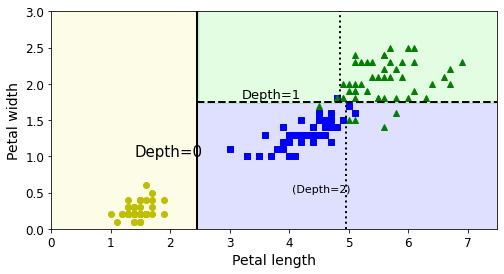

In [10]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

plt.savefig("decision_tree_decision_boundaries_plot")
plt.show()

## *Question 1: Predicting with Decision Trees*
From the above plot, consider the following question:

- What trend(s) are observed in the data with regards to petal length?

Use this answer to answer the following question.


Is petal length a good attribute for distinguishing flowers? Please answer "yes" or "no", and think about why.

In [11]:
ans = "yes"

In [12]:
grader.grade(test_case_id = 'test_case_petal_length', answer = ans)

Correct! You earned 1.0/1.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **Predicting with Decision Trees**

To get a better understanding of our dataset, we can look at the probabilities with which our decision tree classifier is expected to assign a given data point to each of the three different classes of flowers.

In [13]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

From this information, we can make an educated guess about which class of flower our data point is likely to be assigned to by the classifier.

In [14]:
tree_clf.predict([[5, 1.5]])

array([1])

Since class 1 has the highest class probability, our classifier will assign point (5,1.5) to class 1. 

Now it's your turn! Predict the class and probability for a petal with length 4.9 and width 2.0. Please note we are looking for *numerical* answers here, no arrays!

NOTE: Round decimals to the hundredths place. Classes are indexed from zero.

In [27]:
# TODO: Predict the class and probability for a petal with length 4.9 and width 2.0

predicted_class = int(tree_clf.predict([[4.9, 2.0]]))
predicted_prob = np.max(np.round(tree_clf.predict_proba([[4.9, 2.0]]), 2))

In [28]:
grader.grade(test_case_id = 'test_case_pred', answer = (predicted_class, predicted_prob))

Correct! You earned 2.0/2.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **Properties**

## *Question 2: Scale Invariance*

If all features are multiplied by a common factor, what will happen to our decision tree classifier? Use the code provided above and describe your findings. What if you only scale one feature and keep the other feature the same?


In [29]:
# get the new, scaled dataset
scaled_X = X*10

# TODO: train a decision tree classifier using the scaled data & procedure from above and compare it with the original model
# NOTE: Use max_depth of 2 and random_state of 42.

tree_clf = DecisionTreeClassifier(max_depth = 2, random_state = 42)
tree_clf.fit(scaled_X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

We used the model trained on unscaled data to predict the class for a petal with length 4.9 and width 2.0. Let's scale this data up 10 times and predict the class and probability using this new model trained on scaled data and see if anything changes. What does the result tell you?

NOTE: Round decimals to the hundredths place. Classes are indexed from zero.

In [30]:
# TODO: Predict the class and probability for a petal with length 49 and width 20. 

predicted_class_scaled = int(tree_clf.predict([[49, 20]]))
predicted_prob_scaled = np.max(np.round(tree_clf.predict_proba([[49, 20]]), 2))

In [31]:
grader.grade(test_case_id = 'test_case_pred_scaled', answer = (predicted_class_scaled, predicted_prob_scaled))

Correct! You earned 2.0/2.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## *Question 3: Missing values*

We could use the following code to examine the effect of missing values. We generate a new dataset with 10 missing values and refit the model. Please compare the refitted model with the original one? Is there significant difference between them? Please describe your findings and analyze the possible reasons.

In [32]:
# random sample 10 points and replace the first features with -1

indices = np.random.randint(0, len(X), size = 10)
X_miss = X.copy()
X_miss[indices, 0] = -1

In [33]:
# TODO: Train a new DecisionTreeClassifier on the new dataset X_miss
# NOTE: Use max_depth of 2 and random_state of 42.

tree_clf = DecisionTreeClassifier(max_depth = 2, random_state = 42)
tree_clf.fit(X_miss, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

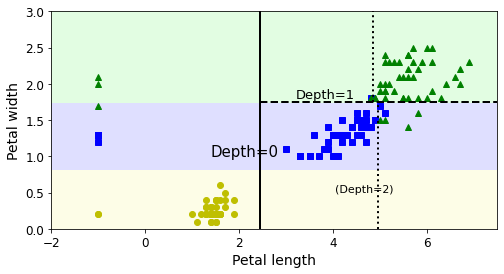

In [34]:
# visualize
export_graphviz(
        tree_clf,
        out_file="iris_tree.dot",
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X_miss, y,axes=[-2, 7.5, 0, 3])
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

plt.savefig("decision_tree_decision_boundaries_plot")
plt.show()

In [35]:
# the real label
y[indices]

array([2, 1, 0, 2, 1, 0, 2, 2, 1, 1])

In [36]:
# the predictions on the missing points
tree_clf.predict(X_miss[indices])

array([2, 1, 0, 1, 1, 0, 2, 2, 1, 1])

Look at the predictions vs. the real labels and the visual. Is there a significant difference between the models? Please answer "yes" or "no".

Think about why this is.

In [37]:
ans = "no"

In [38]:
grader.grade(test_case_id = 'test_case_missing_val', answer = ans)

Correct! You earned 1.0/1.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## *Question 4: Outliers*

If we add some outliers to the data, what will happen to the decision tree? Please explore this question and describe your findings.

In [39]:
# random sample 10 points and replace the first features with petal length 25

indices = np.random.randint(0, len(X), size = 10)
X_out = X.copy()
X_out[indices, 0] = 25

# TODO: Train a new DecisionTreeClassifier on the new dataset X_out. Use max_depth of 2 and random_state of 42.

tree_clf = DecisionTreeClassifier(max_depth = 2, random_state=42)
tree_clf.fit(X_out, y)


DecisionTreeClassifier(max_depth=2, random_state=42)

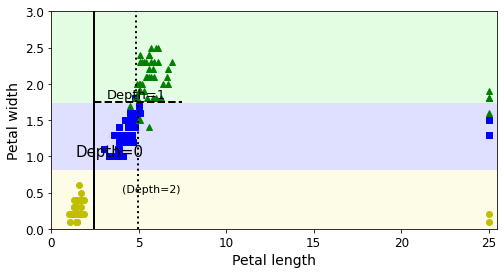

In [40]:
# visualize
export_graphviz(
        tree_clf,
        out_file="iris_tree.dot",
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X_out, y,axes=[0, 25.5, 0, 3])
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

plt.savefig("decision_tree_decision_boundaries_plot")
plt.show()

Are decision trees sensitive to outliers? Please answer "yes" or "no". Please also include the real labels and the predicted labels.

In [41]:
ans = "no"
real_labels = y[indices]
predicted_labels = tree_clf.predict(X_out[indices])

In [42]:
grader.grade(test_case_id = 'test_case_outliers', answer = (ans, real_labels, predicted_labels))

Correct! You earned 3.0/3.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **Disadvantage: instability**




For all of their advantages, decision trees are susceptible to small changes in training data. Such changes can cause large fluctuations in the structure of the decision tree that in turn leads to instability.

To demonstrate this sensitivity, we will exclude data pertaining to the widest Iris-Versicolor flower from our original training set.

In [43]:
X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)] # widest Iris-Versicolor flower

array([[4.8, 1.8]])

In [44]:
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

DecisionTreeClassifier(max_depth=2, random_state=40)

We can now visualize the effect on our decision boundaries as a result of this change in the training dataset.

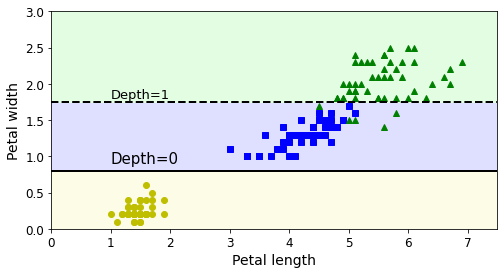

In [45]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

plt.savefig("decision_tree_instability_plot")
plt.show()

Notice what happens to our decision tree just by removing a single data point. Does our tree get more complex (ie. deeper), or less complex (ie. shallower)?

Think about why this is. Why is that one datapoint so important to the structure of our outputted decision tree?

In [53]:
# TODO: Observe the number of decision tree splits in the original tree (first visual of this worksheet) and the number of splits in this new tree we just created.

original_num_splits = 3 
new_num_splits = 2

In [54]:
grader.grade(test_case_id = 'test_case_instability', answer = (original_num_splits, new_num_splits))

Correct! You earned 2.0/2.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## *Question 5: Coordinate-based*

From this experiment, consider the following questions:

- How were the decision boundaries affected compared to those of the original plot?
- Why did the change in the training data affect the decision boundaries?
- What would be the effect on the decision boundaries if you made other changes to the training data?

We can explore this idea further using a moons dataset, which is a toy dataset used to visualize classification algorithms.
Here we observe the effect of setting the minimum number of samples per leaf on our decision boundaries.

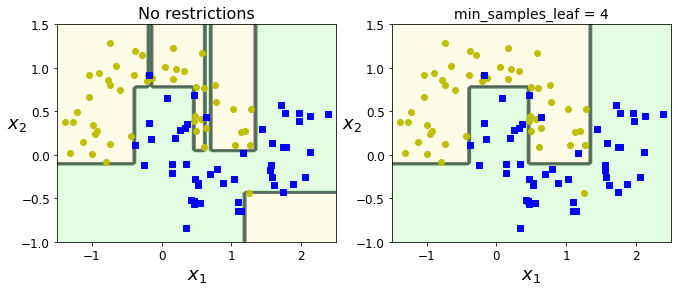

In [55]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)

plt.savefig("min_samples_leaf_plot")
plt.show()

Next we will investigate how the decision boundaries change with rotation of data points. We start by rotating the Iris Dataset data points.

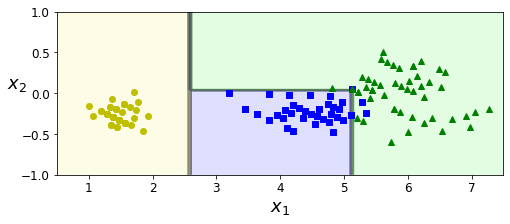

In [56]:
angle = np.pi / 180 * 20
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xr = X.dot(rotation_matrix)

tree_clf_r = DecisionTreeClassifier(random_state=42)
tree_clf_r.fit(Xr, y)

plt.figure(figsize=(8, 3))
plot_decision_boundary(tree_clf_r, Xr, y, axes=[0.5, 7.5, -1.0, 1], iris=False)

plt.show()

Similarly, we can see how the rotation of the data points in our moons dataset affects our final decision boundaries.

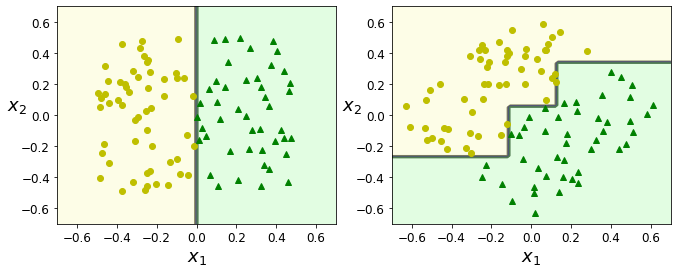

In [57]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.subplot(122)
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)

plt.savefig("sensitivity_to_rotation_plot")
plt.show()

1. Generate a moons dataset using `make_moons(n_samples=10000, noise=0.4)`.

We will be adding `random_state=42` in our function call to make this notebook's output constant:

In [58]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

2. Split the moons dataset into a training set and a test set using `train_test_split()`.

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

3. Use grid search with cross-validation (with the help of the `GridSearchCV` class) to find good hyperparameter values for a `DecisionTreeClassifier`. Hint: try various values for `max_leaf_nodes`.

In [60]:
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [61]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=17, random_state=42)

4. Train the `DecisionTreeClassifier` on the full training set using these hyperparameters, and measure your model's performance on the test set. You should get roughly 85% to 87% accuracy.

By default, `GridSearchCV` trains the best model found on the whole training set (you can change this by setting `refit=False`), so we don't need to do it again. We can simply evaluate the model's accuracy:

In [62]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8695

Submit your accuracy score. Please round to the hundredths place.

In [63]:
acc = 0.87

In [64]:
grader.grade(test_case_id = 'test_case_coordinate', answer = acc)

Correct! You earned 1.0/1.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


##**Exercise**: Grow a Forest (Optional)

The purpose of this part is to help you understand the basic concept of `Forest`.

1. Continuing from the previous exercise, generate 1,000 subsets of the training set, each containing 100 instances selected randomly. \\
Hint: you can use Scikit-Learn's `ShuffleSplit` class for this.

In [65]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

2. Train one decision tree on each subset, using the best hyperparameter values found above. Evaluate these 1,000 decision trees on the test set. Since they were trained on smaller sets, these decision trees will likely perform worse than the first decision tree, achieving only about 80% accuracy.

In [66]:
from sklearn.base import clone

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.8054499999999999

3. Now comes the magic. For each test set instance, generate the predictions of the 1,000 decision trees, and keep only the most frequent prediction (you can use SciPy's `mode()` function for this). This gives you _majority-vote predictions_ over the test set.

In [67]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [68]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

4. Evaluate these predictions on the test set: you should obtain a slightly higher accuracy than your first model (about 0.5 to 1.5% higher). Congratulations, you have trained a Random Forest classifier!

In [69]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.872

## Submitting to the Autograder

First of all, please run your notebook from beginning to end and ensure you are getting all the points from the autograder!

Now go to the File menu and choose "Download .ipynb".  Go to [Gradescope](https://www.gradescope.com/courses/409970) and:

1. From "File" --> Download both .ipynb and .py files
1. Name these files `Decision_Trees_WS.ipynb` and `Decision_Trees_WS.py` respectively
1. Sign in using your Penn email address (if you are a SEAS student we recommend using the Google login) and ensure  your class is "CIS 5200"
1. Select **Worksheet: Decision Trees**
1. Upload both files
1. PLEASE CHECK THE AUTOGRADER OUTPUT TO ENSURE YOUR SUBMISSION IS PROCESSED CORRECTLY!

You should be set! Note that this assignment has 10 autograded points that will show up upon submission. Points are awarded based on a combination of correctness and sufficient effort. 